## Import and runtime info

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import warnings
import kagglehub
from dotenv import load_dotenv
warnings.filterwarnings("ignore")

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
    BATCH_SIZE = 32
else:
    print("Failed to detect a GPU.")
    BATCH_SIZE = 64
    
print('tensorflow version: ' + tf.__version__)

np.random.seed(69)
tf.random.set_seed(69)

load_dotenv()

os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

2024-12-12 17:39:32.031855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 17:39:32.043560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 17:39:32.047432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 17:39:32.056661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
tensorflow version: 2.17.0


I0000 00:00:1734021575.312284   72239 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734021575.493861   72239 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734021575.493962   72239 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


## load data set

In [2]:
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")
cell_images_path = os.path.join(path, "cell_images")

print("Path to dataset files:", path)
print("Contents of cell_images folder:", os.listdir(cell_images_path))

Path to dataset files: /home/mba/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1
Contents of cell_images folder: ['Parasitized', 'Uninfected', 'cell_images']


## preview

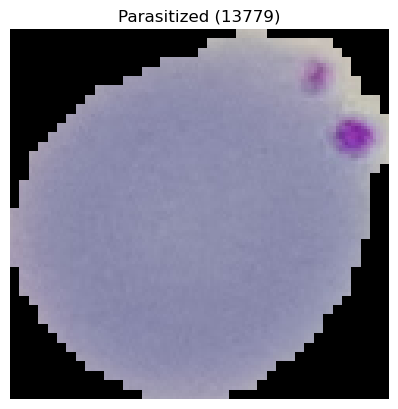

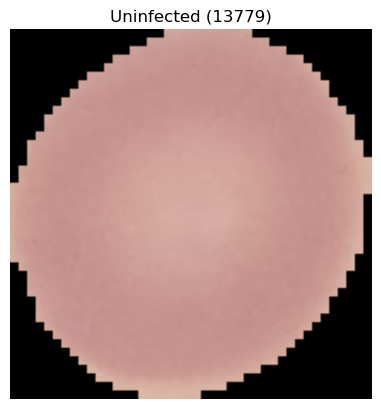

In [3]:
parasitized_images = glob.glob(os.path.join(cell_images_path, "Parasitized", "*.png"))
uninfected_images = glob.glob(os.path.join(cell_images_path, "Uninfected", "*.png"))

image = Image.open(parasitized_images[0])
plt.figure()
plt.imshow(image)
plt.axis("off")
plt.title("Parasitized (" + str(len(parasitized_images)) + ")")
plt.show()

image = Image.open(uninfected_images[0])
plt.figure()
plt.imshow(image)
plt.axis("off")
plt.title("Uninfected (" + str(len(uninfected_images)) + ")")
plt.show() 

## Preprocessing

In [4]:
images = []
labels = []

target_width = 128
target_height = 128

for img_path in uninfected_images:
    img = load_img(img_path, target_size=(target_width, target_height))  # Resize to (128x128)
    images.append(img_to_array(img))
    labels.append(0)  # Uninfected 

# Load images and assign labels
for img_path in parasitized_images:
    img = load_img(img_path, target_size=(target_width, target_height))  # Resize to (128x128)
    images.append(img_to_array(img))
    labels.append(1)  # Parasitized

# Convert to numpy arrays and normalize pixel values
images = np.array(images, dtype="float32") / 255.0
labels = np.array(labels)

# use 30% of full dataset as validation and test data
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
# then: use 50% for validation and 50% for test  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

print(f"Training data: {len(X_train)}")
print(f"Validation data: {len(X_val)}")
print(f"Testing data: {len(X_test)}")

Images shape: (27558, 128, 128, 3)
Labels shape: (27558,)
Training data: 19290
Validation data: 4134
Testing data: 4134


## Model Architecture

In [8]:
warnings.filterwarnings('ignore')

from keras import layers, models

model = models.Sequential([
    #Input layer   
    layers.Input(shape=(128, 128, 3)),  # Explicit Input layer

    # data augmentation
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

    # neural network   
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu, padding="SAME"),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.relu, padding="SAME"),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation=tf.nn.relu, padding="SAME"),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Flatten(),  # Flatten the feature maps

    # Use a dense (fully connected) layer to perform a classification based on features
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    
    # Output layer
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()     

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
LEARNING_RATE_PARAM = 0.001

# Learning Rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

# Optimizers
_rms = keras.optimizers.RMSprop(learning_rate=lr_schedule)
_sgd = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PARAM, momentum=0.9, nesterov=True)
_adam = keras.optimizers.Adam(learning_rate=LEARNING_RATE_PARAM)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

OPTIMIZER_PARAM = _rms
CALLBACKS = [early_stopping]
EPOCH_PARAM = 50


In [10]:
model.compile(
    optimizer=OPTIMIZER_PARAM,
    loss="binary_crossentropy", 
    metrics=['accuracy']
)

print(f"Using batch size: {BATCH_SIZE}")
print(f"Using learning rate: {LEARNING_RATE_PARAM}")
print(f"Using optimizer: {OPTIMIZER_PARAM}")
print(f"Epoch size: {EPOCH_PARAM}")

history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCH_PARAM,
        batch_size=BATCH_SIZE, # 32 - GPU, 64 - CPU
        callbacks=CALLBACKS
    )

Using batch size: 32
Using learning rate: 0.001
Using optimizer: <keras.src.optimizers.rmsprop.RMSprop object at 0x7f92f00d6210>
Epoch size: 50


2024-12-12 17:41:25.775622: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3792568320 exceeds 10% of free system memory.
2024-12-12 17:41:26.966346: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3792568320 exceeds 10% of free system memory.


Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6766 - loss: 0.5776 - val_accuracy: 0.9260 - val_loss: 0.2132
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9273 - loss: 0.2181 - val_accuracy: 0.9412 - val_loss: 0.1657
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9431 - loss: 0.1779 - val_accuracy: 0.9383 - val_loss: 0.1850
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9472 - loss: 0.1720 - val_accuracy: 0.9344 - val_loss: 0.2061
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9487 - loss: 0.1662 - val_accuracy: 0.9436 - val_loss: 0.1683
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9497 - loss: 0.1646 - val_accuracy: 0.9296 - val_loss: 0.2026
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9496 - loss: 0.1586 - val_accuracy: 0.9453 - val_loss: 0.1565
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9512 - loss: 0.1607 - val_accu

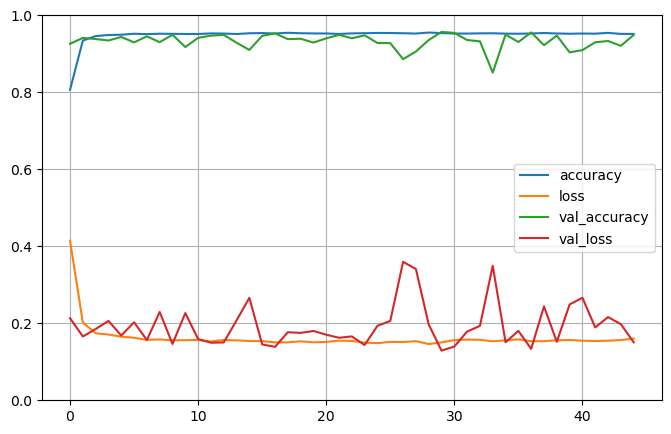

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
     

In [12]:
model.evaluate(X_test, y_test)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9453 - loss: 0.1476


[0.13495026528835297, 0.9508950114250183]